In [6]:
from urllib.parse import urlencode
import pandas

def get_series(sql):
    url = "https://sedlabanki-housing-mtckiezzpq-lz.a.run.app/housing.csv?" + urlencode({"sql": sql})
    return pandas.read_csv(url, parse_dates=['date'], index_col='date')

In [7]:
import datetime as dt
import calendar

def parse_date(s):
    d = dt.datetime.strptime(s, '%YM%m')
    _, last_day_of_month = calendar.monthrange(d.year, d.month)
    d = d.replace(day=last_day_of_month)
    return d

inflation = pandas.read_csv(
    'iceland_inflation.csv', 
    parse_dates=[0], 
    delimiter=';', 
    encoding='latin-1', 
    date_parser=parse_date,
    names=['date', 'inflation'],
    header=0,
    index_col='date',
)
inflation['multiplier'] = inflation['inflation'] / inflation['inflation'].iloc[-1]

def merge_and_inflation_adjust_value(df):
    df = df.merge(inflation, on="date", how='left')
    df['value'] = df['value'] * df['multiplier']
    return df

from matplotlib.ticker import FuncFormatter

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 140

def set_milljardur_formatter(ax):
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y / 1_000_000_000:,.0f}')) 
    # or percentages:
    # ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:,.0f}%')) 


<Figure size 840x560 with 0 Axes>

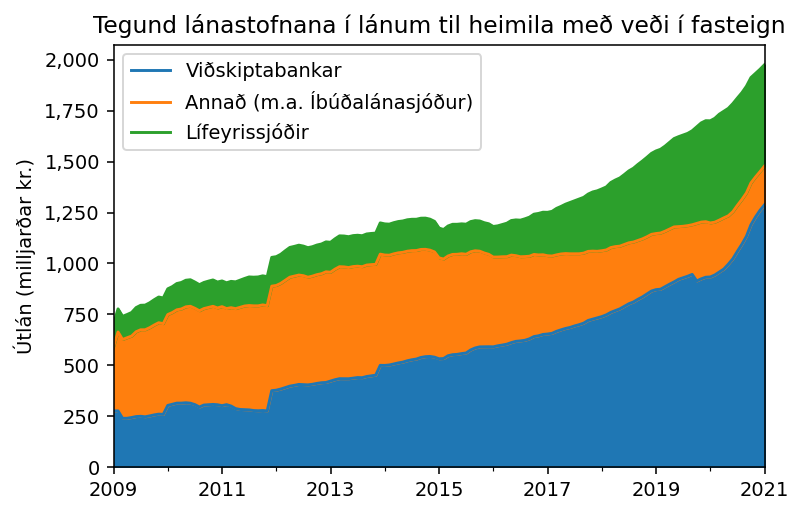

In [8]:
df = get_series("""select 
  date, 
  institute, 
  sum(value) as value
from mortgages 
where strftime('%Y', date) > "2008" and date <= (
  select max(date) as max_date from mortgages where institute = 'bank' union
  select max(date) as max_date from mortgages where institute = 'pension' union
  select max(date) as max_date from mortgages where institute = 'other' order by max_date limit 1)  
group by date, institute 
order by date, institute""")
df = merge_and_inflation_adjust_value(df)
df = df.pivot(columns="institute", values="value")
fig = plt.figure()
ax = df.plot.area(stacked=True)
plt.title('Tegund lánastofnana í lánum til heimila með veði í fasteign')
ax.legend(['Viðskiptabankar', 'Annað (m.a. Íbúðalánasjóður)', 'Lífeyrissjóðir'])
ax.set_ylabel("Útlán (milljarðar kr.)")
ax.set_xlabel(None)
set_milljardur_formatter(ax)

<Figure size 840x560 with 0 Axes>

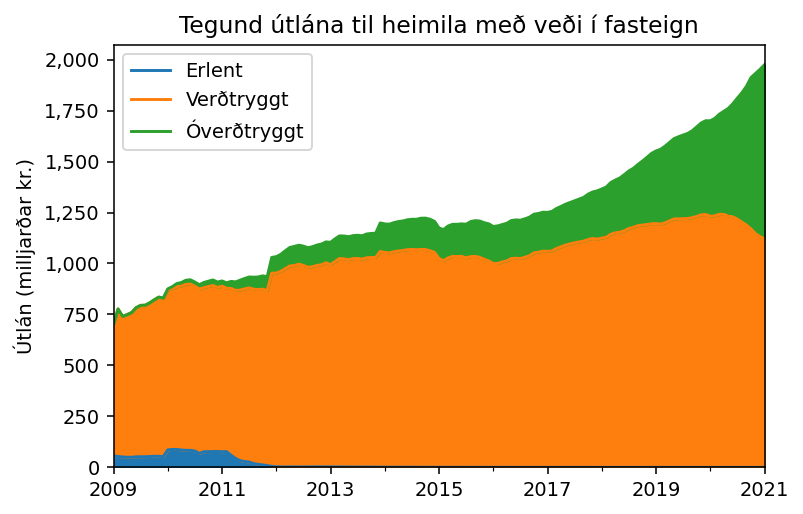

In [9]:
df = get_series("""select 
  date, 
  category, 
  sum(value) as value
from mortgages 
where strftime('%Y', date) > "2008" and date <= (
  select max(date) as max_date from mortgages where institute = 'bank' union
  select max(date) as max_date from mortgages where institute = 'pension' union
  select max(date) as max_date from mortgages where institute = 'other' order by max_date limit 1)  
group by date, category 
order by date, category""")
df = merge_and_inflation_adjust_value(df)
df = df.pivot(columns="category", values="value")
fig = plt.figure()
ax = df.plot.area(stacked=True)
plt.title('Tegund útlána til heimila með veði í fasteign')
ax.legend(['Erlent', 'Verðtryggt', 'Óverðtryggt'])
ax.set_ylabel("Útlán (milljarðar kr.)")
ax.set_xlabel(None)
set_milljardur_formatter(ax)